# The task statement

##### The task is to use PCA (principal component analysis) in order to optimize number of features and to classify hand-written numbers

# Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
import matplotlib.pyplot as plt
import seaborn as sb
import missingno as msno
import random as rd

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPool2D, BatchNormalization, Conv2D, MaxPooling2D, Flatten
#Image preprocessing
from keras.layers import Rescaling, Resizing, CenterCrop 
#Image augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import RandomCrop, RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
def show_training_history(history):
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(history.history['loss'], color = 'b', label = 'Training loss')
    ax[0].plot(history.history['val_loss'], color = 'r', label = 'Validation loss', axes = ax[0])
    legend = ax[0].legend(loc = 'best', shadow = True)
    ax[1].plot(history.history['accuracy'], color = 'b', label = 'Training accuracy')
    ax[1].plot(history.history['val_accuracy'], color = 'r',label = 'Validation accuracy')
    legend = ax[1].legend(loc = 'best', shadow = True)

In [6]:
def show_confusion_matrix(labels_test, labels_predicted):
    plt.figure(figsize = (10, 7))
    sb.heatmap(
        confusion_matrix(labels_test, labels_predicted),
        annot = True, fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

# Dataset

In [7]:
from sklearn.datasets import fetch_openml

dataset = fetch_openml('mnist_784', version = 1, cache = True, parser = 'auto')
x = dataset['data']
y = dataset['target']

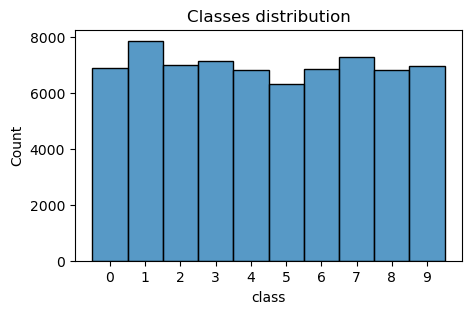

In [8]:
plt.figure(figsize = (5, 3))
plt.title('Classes distribution')
sb.histplot(y, discrete = True)
plt.show()

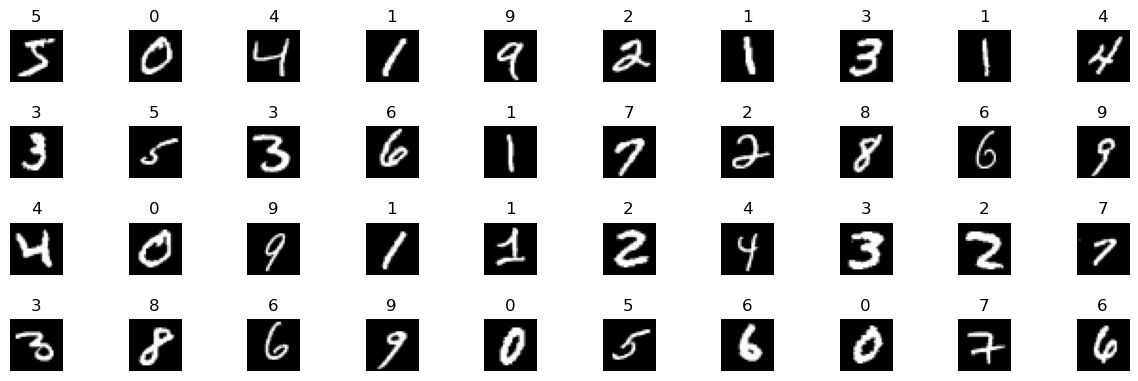

In [9]:
plt.subplots(4, 10, figsize = (12, 4))
plt.tight_layout()
for i in range(0, 40):
    plt.subplot(4, 10, i + 1)
    plt.axis('off')
    plt.gca().set_title(y[i])
    plt.imshow(x.iloc[[i]].to_numpy().reshape(28, 28), cmap = 'gray')
plt.show()  

# Preprocessing

In [13]:
y_int = y.astype(np.int8)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns = x.columns)

# Train, test and validation sets

In [14]:
x_train_, x_test, y_train_, y_test = train_test_split(x_scaled, y_int, test_size = 0.20, random_state = 42, shuffle = True)
x_train, x_validation, y_train, y_validation = train_test_split(x_train_, y_train_, test_size = 0.05, random_state = 42)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_validation_categorical = to_categorical(y_validation)
print(f'x train: {x_train.shape}')
print(f'y train: {y_train.shape}')
print()
print(f'x test: {x_test.shape}')
print(f'y test: {y_test.shape}')
print()
print(f'x validation: {x_validation.shape}')
print(f'y validation: {y_validation.shape}')

x train: (53200, 784)
y train: (53200,)

x test: (14000, 784)
y test: (14000,)

x validation: (2800, 784)
y validation: (2800,)


# Perceptron classification

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                39250     
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                1020      
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
Total params: 43,030
Trainable params: 43,030
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
832/832 [========================

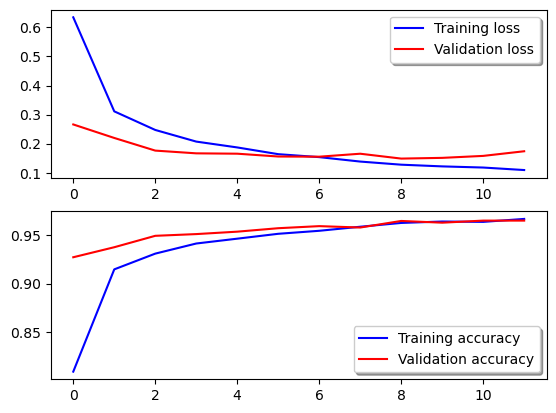

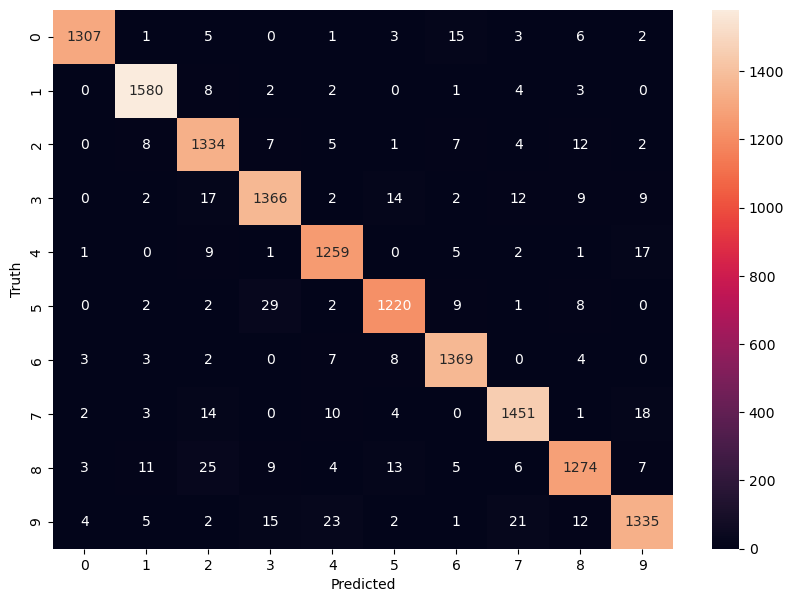

In [15]:
perceptron = Sequential([
    Dense(50, activation = 'relu', input_dim = x_train.shape[1]),
    Dense(50, activation = 'relu'),
    Dropout(0.5),
    Dense(20, activation = 'relu'),
    Dense(y_train_categorical.shape[1], activation = 'softmax')
])

perceptron.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(perceptron.summary())

epochs = 100
early_stopping_monitor_perceptron = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 1e-4, 
    patience = 3,
    verbose = 1,
    mode = 'auto',
    restore_best_weights = False)

perceptron_history = perceptron.fit(
    x_train, 
    y_train_categorical, 
    validation_data = (x_validation, y_validation_categorical),
    batch_size = 64,
    callbacks = [early_stopping_monitor_perceptron],
    epochs = epochs)

loss, accuracy = perceptron.evaluate(x_test, y_test_categorical)  

print('---------')
print(f'Accuracy: {accuracy}, loss: {loss}')
print('---------')

show_training_history(perceptron_history)
y_predicted_from_perceptron = np.argmax(perceptron.predict(x_test), axis = 1)
print(classification_report(y_test, y_predicted_from_perceptron))
show_confusion_matrix(y_test, y_predicted_from_perceptron)

# PCA

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 210)
pca_x = pca.fit_transform(x_scaled)
pca_x

array([[-0.89171992, -4.92971091, -0.09303755, ...,  0.30782557,
         0.87969787,  0.49237276],
       [ 8.81353008, -7.51756037, -3.71418483, ...,  0.29774802,
        -0.38454339, -0.53824637],
       [ 2.20483551,  9.82446134, -5.75248742, ..., -0.52754554,
         0.35092356,  1.8424251 ],
       ...,
       [-5.22259496, -1.18431566, -4.75472538, ..., -0.84225814,
         0.66497094,  0.21471111],
       [-2.1777285 , -6.99503192, -3.22873677, ..., -0.25078572,
         1.04144294,  0.96811343],
       [11.77787165, -5.40298112,  2.32272518, ...,  0.07362972,
        -0.77083886,  0.84504382]])

In [28]:
per_var = np.round(pca.explained_variance_ratio_ * 100.0, decimals = 2)
labels = [str(i) for i in range(1, len(per_var) + 1)]
print(f'Explained varience: {np.sum(per_var)}')

Explained varience: 87.49000000000001


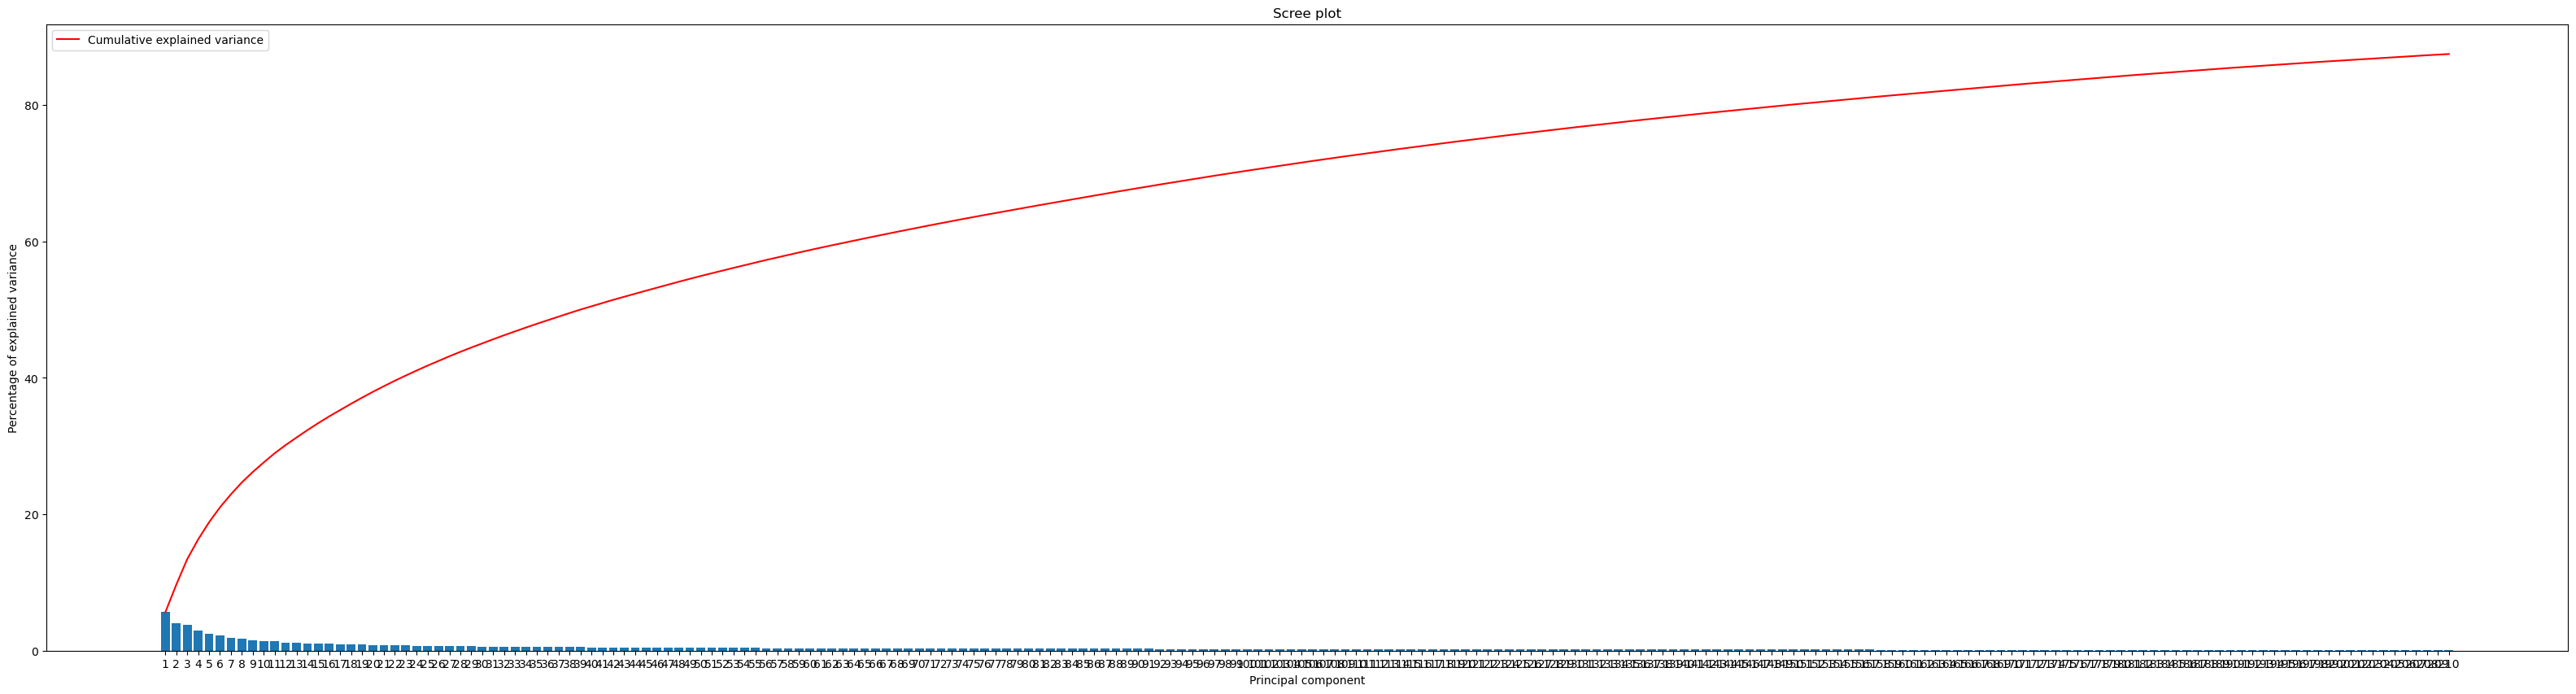

In [31]:
plt.figure(figsize = (40, 10))
plt.bar(x = range(1, len(per_var) + 1), height = per_var, tick_label = labels)
plt.plot(range(1, len(per_var) + 1), np.cumsum(per_var), c = 'red', label = 'Cumulative explained variance')
plt.legend(loc = 'upper left')
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal component')
plt.title('Scree plot')
plt.show()

## Train, test and validation sets (PCA)

In [33]:
x_train_, x_test, y_train_, y_test = train_test_split(pca_x, y_int, test_size = 0.20, random_state = 42, shuffle = True)
x_train, x_validation, y_train, y_validation = train_test_split(x_train_, y_train_, test_size = 0.05, random_state = 42)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_validation_categorical = to_categorical(y_validation)
print(f'x train: {x_train.shape}')
print(f'y train: {y_train.shape}')
print()
print(f'x test: {x_test.shape}')
print(f'y test: {y_test.shape}')
print()
print(f'x validation: {x_validation.shape}')
print(f'y validation: {y_validation.shape}')

x train: (53200, 210)
y train: (53200,)

x test: (14000, 210)
y test: (14000,)

x validation: (2800, 210)
y validation: (2800,)


## Perceptron classification (PCA)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 50)                10550     
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 20)                1020      
                                                                 
 dense_11 (Dense)            (None, 10)                210       
                                                                 
Total params: 14,330
Trainable params: 14,330
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
832/832 [========================

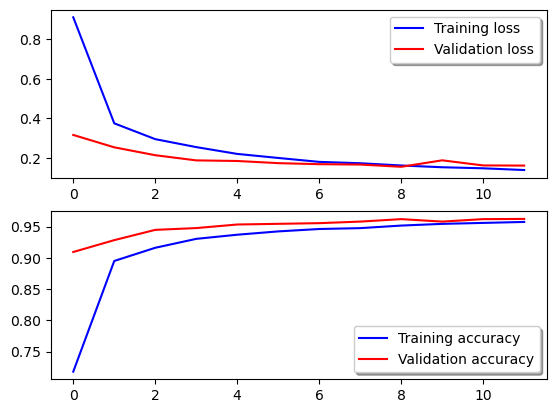

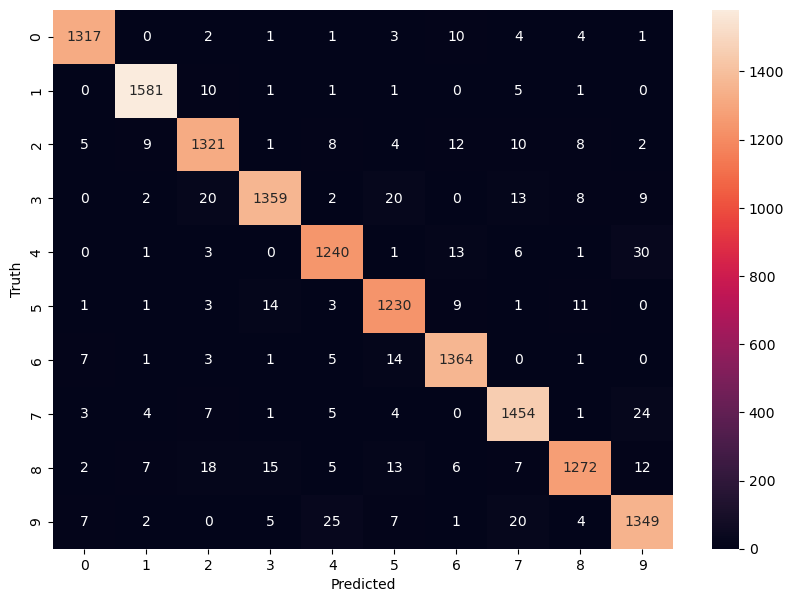

In [34]:
perceptron = Sequential([
    Dense(50, activation = 'relu', input_dim = x_train.shape[1]),
    Dense(50, activation = 'relu'),
    Dropout(0.5),
    Dense(20, activation = 'relu'),
    Dense(y_train_categorical.shape[1], activation = 'softmax')
])

perceptron.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(perceptron.summary())

epochs = 100
early_stopping_monitor_perceptron = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 1e-4, 
    patience = 3,
    verbose = 1,
    mode = 'auto',
    restore_best_weights = False)

perceptron_history = perceptron.fit(
    x_train, 
    y_train_categorical, 
    validation_data = (x_validation, y_validation_categorical),
    batch_size = 64,
    callbacks = [early_stopping_monitor_perceptron],
    epochs = epochs)

loss, accuracy = perceptron.evaluate(x_test, y_test_categorical)  

print('---------')
print(f'Accuracy: {accuracy}, loss: {loss}')
print('---------')

show_training_history(perceptron_history)
y_predicted_from_perceptron = np.argmax(perceptron.predict(x_test), axis = 1)
print(classification_report(y_test, y_predicted_from_perceptron))
show_confusion_matrix(y_test, y_predicted_from_perceptron)